# Regressions

All sections feature a linear regression and multilayer perceptron algorithm to evaluate the relationship between SPY and VIX, including their options.

### 1. SPY vs. VIX (Daily, 5 years)

### 2. SPY vs. VIX call + put (30 minutes, 6 months)

### 3. VIX vs. SPY call + put (Daily, 2 years)

*All data was obtained directly from Bloomberg Terminal, thanks to the Stevens School of Business Hanlon Financial Systems Center.*

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neural_network import MLPRegressor as MLPR
from sklearn.linear_model import LinearRegression as LM
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse

This project seeks to understand the connection between SPY and VIX through the lens of linear regression and a machine learning regression.

# SPY vs. VIX Daily Percent Changes

This section attempts to evaluate a linear relationship between SPY and VIX daily percent changes. Data spans 5 years, up to 12/15/2023. Preprocessing of data includes sorting data from oldest to newest, backfilling newer data with previous prices if there exists a 'NA' value, and transforming the data to make a train-test split; for these models, a train-test split of 80/20 was selected because there is sufficiently enough data for the regressions to predict the test points, so more was allocated to training.

In [14]:
# VIX and SPY data, daily over 5 years (source: Bloomberg terminal)
dailyVIXSPY = pd.read_excel("BB_SPY_vs_VIX_Daily5y.xlsx").drop("Date", axis=1).sort_index(ascending=False).fillna(method='ffill').pct_change().dropna()

# normalizing data
scaler=MinMaxScaler(feature_range=(0,1))
dfScaled = scaler.fit_transform(dailyVIXSPY)

# Split data into the features and target variable
X = dfScaled[:, :-1]
Y = dfScaled[:, -1]

# assign train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)


In [15]:
# construct linear regression model
LinearModel = LM()
LinearModel.fit(X_train, Y_train)
score=LinearModel.score(X_test, Y_test)
print(f'Ordinary Least Squares Score: {score:0.2f}')

# linear model predictions
predLM = LinearModel.predict(X_test)
predLM = scaler.inverse_transform(np.column_stack((X_test, predLM.reshape(-1,1))))

Ordinary Least Squares R^2: 0.53


In [25]:
# construct MLP regression model
mlpModel = MLPR(hidden_layer_sizes=(16, 16), activation='relu', solver='adam', max_iter=500)
mlpModel.fit(X_train, Y_train)
score=mlpModel.score(X_test, Y_test)
print(f'Multilayer Perceptron Score: {score:0.2f}')

# multilayer perceptron predictions
predMLP = mlpModel.predict(X_test)
predMLP = scaler.inverse_transform(np.column_stack((X_test, predMLP)))

Multilayer Perceptron R^2: 0.50


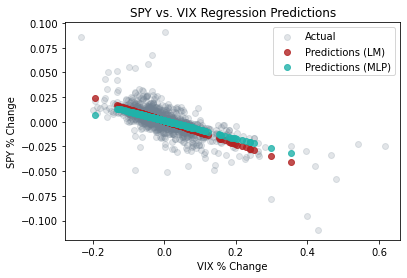

In [27]:
plt.scatter(dailyVIXSPY['VIX Index  (R1)'], dailyVIXSPY['SPY US Equity  (L1)'], label='Actual', alpha=0.2, c="slategrey")
plt.scatter(predLM[:,0], predLM[:, 1], label='Predictions (LM)', alpha=0.8, c="firebrick")
plt.scatter(predMLP[:, 0], predMLP[:, 1], label='Predictions (MLP)', alpha=0.8, c="lightseagreen")
plt.xlabel('VIX % Change')
plt.ylabel('SPY % Change')
plt.title('SPY vs. VIX Regression Predictions')
plt.legend()
plt.show()

# SPY vs. VIX Options (30-minute Percent Changes)

This section studies the connection between the VIX traded price and SPY options (calls and puts). Data is aggregated weekly for a 2 year period. SPY options consist of SPY C460 and P450, both expiring on December 15, 2023. Linear regression and multilayer perceptrons are again the choice of model here. Despite initial expectations, the linear regression exhibits a somewhat low coefficient of determination. Because the VIX options in question were not first issued until early 2023, 6-month 30 minute percent change data was used as opposed to daily to increase the amount of data for training and testing.

In [111]:
SPYVIXoptions = pd.read_excel("BB_SPY_VIXC20_VIXP20.xlsx").drop("Date", axis=1).sort_index(ascending=False).fillna(method='ffill').pct_change().dropna()

# Split data into the features and target variable
X = SPYVIXoptions[["VIX US 12/20/23 C16 Index - Last Price (R1)", "VIX US 12/20/23 P16 Index - Last Price (R1)"]]
Y = SPYVIXoptions["SPY US Equity - Last Price (L1)"]

# assign train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [112]:
# construct linear regression model
LinearModel = LM()
LinearModel.fit(X_train, Y_train)
score=LinearModel.score(X_test, Y_test)
print(f'Ordinary Least Squares Score: {score:0.5f}')

# linear model predictions
predLM = LinearModel.predict(X_test)
print(f'Mean Squared Error: {mse(Y_test, predLM)}')

Ordinary Least Squares Score: 0.33493


In [121]:
# construct MLP regression model
mlpModel = MLPR(hidden_layer_sizes=(64, 32, 16), activation='relu', solver='adam', max_iter=500)
mlpModel.fit(X_train, Y_train)
score=mlpModel.score(X_test, Y_test)
print(f'Multilayer Perceptron Score: {score:0.5f}')

# multilayer perceptron predictions
predMLP = mlpModel.predict(X_test)
print(f'Mean Squared Error: {mse(Y_test, predMLP):0.5f}')


Multilayer Perceptron Score: -41.24748


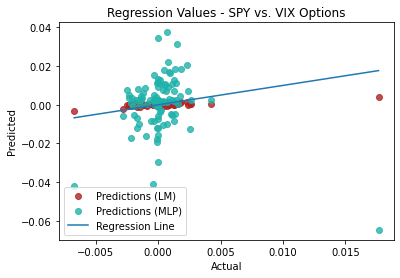

In [123]:
plt.scatter(Y_test, predLM, label='Predictions (LM)', alpha=0.8, c="firebrick")
plt.scatter(Y_test, predMLP, label='Predictions (MLP)', alpha=0.8, c="lightseagreen")
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], label="Regression Line")
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Regression Values - SPY vs. VIX Options')
plt.legend()
plt.show()

# VIX vs. SPY Options (daily percent change)

Similar to the previous section, this section provides two regression models capturing the relationship between the VIX index and the value of SPY options. For this, 2 years of daily percent changes are used for the training and testing variables.

In [127]:
VIXSPYoptions = pd.read_excel("BB_VIX_SPYC_SPYP_460.xlsx").drop("Date", axis=1).sort_index(ascending=False).fillna(method='ffill').pct_change().dropna()

# Split data into the features and target variable
X = VIXSPYoptions[["SPY US 01/19/24 C460 Equity - Last Price (L1)", "SPY US 01/19/24 P460 Equity - Last Price (R2)"]]
Y = VIXSPYoptions["VIX Index - Last Price (R1)"]

# assign train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [128]:
# construct linear regression model
LinearModel = LM()
LinearModel.fit(X_train, Y_train)
score=LinearModel.score(X_test, Y_test)
print(f'Ordinary Least Squares Score: {score:0.5f}')

# linear model predictions
predLM = LinearModel.predict(X_test)
print(f'Mean Squared Error: {mse(Y_test, predLM)}')

Ordinary Least Squares Score: 0.25781
Mean Squared Error: 0.0022542576682345193


In [129]:
# construct MLP regression model
mlpModel = MLPR(hidden_layer_sizes=(64, 32, 16), activation='relu', solver='adam', max_iter=500)
mlpModel.fit(X_train, Y_train)
score=mlpModel.score(X_test, Y_test)
print(f'Multilayer Perceptron Score: {score:0.5f}')

# multilayer perceptron predictions
predMLP = mlpModel.predict(X_test)
print(f'Mean Squared Error: {mse(Y_test, predMLP):0.5f}')

Multilayer Perceptron Score: 0.13740
Mean Squared Error: 0.00262


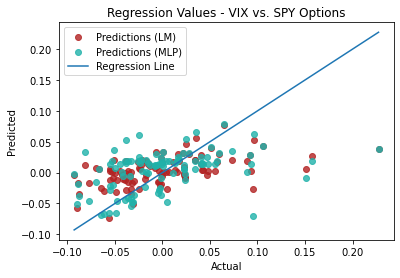

In [130]:
plt.scatter(Y_test, predLM, label='Predictions (LM)', alpha=0.8, c="firebrick")
plt.scatter(Y_test, predMLP, label='Predictions (MLP)', alpha=0.8, c="lightseagreen")
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], label="Regression Line")
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Regression Values - VIX vs. SPY Options')
plt.legend()
plt.show()